In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from nsp import process_dataset, prepare_data, LSTMNSPModel
from utils import Preprocess4Normalization
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

Loading raw data - Data: (9166, 120, 6) Labels: (9166, 120, 3)
Before normalization - Data shape: (9166, 120, 6) [-6.53186037e+00  1.09563701e+00  7.50957234e+00 -9.42993150e-03
 -8.63647463e-03 -1.58691408e-03]
After normalization - Data: (9166, 120, 6) Labels: (9166, 120, 3) [-0.66651636  0.1117997   0.76628289 -0.00942993 -0.00863647 -0.00158691]

Normalized Samples
[-0.61816811  0.1017263   0.81249097 -0.00270081  0.00247192 -0.00222778]
[-0.61558128  0.10407023  0.81467703 -0.00280762  0.00930786 -0.00340271]
[-0.61699007  0.10407024  0.81696024  0.00296021  0.01091003 -0.00820923]


In [ ]:
# Configuration 
INPUT_LEN = 70
PREDICT_LEN = 20
BATCH_SIZE = 32
MODEL_PATH = "lstm_nsp/lstm_nsp_70_20/lstm_nsp_70_20.pt"
PRED_NPY_PATH = "lstm_nsp/lstm_nsp_70_20/lstm_nsp_70_20_predictions.npy"
ACTUAL_NPY_PATH = "lstm_nsp/lstm_nsp_70_20/lstm_nsp_70_20_actuals.npy"

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load normalized data and process
data = np.load("dataset/hhar/data_20_120.npy")
label = np.load("dataset/hhar/label_20_120.npy")

print("Loading raw data - Data:", data.shape, "Labels:", label.shape)
print("Before normalization - Data shape:", data.shape, data[0][0][:])

normalizer = Preprocess4Normalization(feature_len=6)
normalized_data = np.zeros_like(data)

for i in range(len(data)):
    normalized_data[i] = normalizer(data[i])

print("After normalization - Data:", normalized_data.shape, "Labels:", label.shape, normalized_data[0][0][:])
filtered_data, kept_indices, removed_indices = process_dataset(normalized_data, pad=True)
print("Filtered data shapes:")
train_loader, val_loader, test_loader = prepare_data(filtered_data, kept_indices)

Loading raw data - Data: (9166, 120, 6) Labels: (9166, 120, 3)
Before normalization - Data shape: (9166, 120, 6) [-6.53186037e+00  1.09563701e+00  7.50957234e+00 -9.42993150e-03
 -8.63647463e-03 -1.58691408e-03]
After normalization - Data: (9166, 120, 6) Labels: (9166, 120, 3) [-0.66651636  0.1117997   0.76628289 -0.00942993 -0.00863647 -0.00158691]
Number of sequences: 9166
Min length: 5
Max length: 100
Mean length: 96.89
Median length: 100.0
Filtered data shapes:
Total NSP pairs: 91078
Input: torch.Size([70, 6]), Target: torch.Size([20, 6]), Input Pos: torch.Size([70]), Target Pos: torch.Size([20])
Input: torch.Size([70, 6]), Target: torch.Size([20, 6]), Input Pos: torch.Size([70]), Target Pos: torch.Size([20])
Input: torch.Size([70, 6]), Target: torch.Size([20, 6]), Input Pos: torch.Size([70]), Target Pos: torch.Size([20])
Total sequences: 9166
Total NSP pairs: 91078
Average NSP pairs per sequence: 9.94
Train NSP pairs: 72862
Val NSP pairs: 9108
Test NSP pairs: 9108


In [4]:
predictions = np.load(PRED_NPY_PATH)
actuals = np.load(ACTUAL_NPY_PATH)
print("Predictions loaded:", predictions.shape)
print("Actuals loaded:", actuals.shape)
print("First few predictions:", predictions[:1]) 

Predictions loaded: (9108, 20, 6)
Actuals loaded: (9108, 20, 6)
First few predictions: [[[ 0.64791584 -0.30189228  1.2150164  -0.3542047  -0.0874662
   -0.27967978]
  [ 0.9241291  -0.35881352  1.0601405  -0.11849543  0.38345635
   -0.08578894]
  [ 0.7619804  -0.30979937  0.7231958  -0.14933616  0.8051701
    0.10889143]
  [ 0.5688726  -0.02366071  0.6983391   0.25357497  0.28079084
    0.15996636]
  [ 0.5912229   0.05844795  0.7302886   0.54878587 -0.5845778
    0.06437431]
  [ 0.514403   -0.06651832  0.6111937   0.5773208  -0.06566759
   -0.02914951]
  [ 0.36656025 -0.06056737  0.42748985  0.6866275   0.33942825
    0.1433875 ]
  [ 0.29750565  0.09748511  0.4351685   0.3844448   0.14833671
    0.41041544]
  [ 0.31122705  0.13374698  0.5590912  -0.00467269 -0.53770375
    0.55049425]
  [ 0.6029905  -0.01954436  0.9269984  -0.20839219 -0.7703947
    0.6134536 ]
  [ 0.69411886 -0.09017108  1.2482858   0.04710298 -0.45778292
    0.30125153]
  [ 0.845153   -0.09192763  1.2310507   0.327768

In [ ]:
def linear_regression_predict(input_seq, pred_len):
    """Linear regression prediction for all 6 features"""
    predictions = np.zeros((pred_len, 6))
    for feature in range(6):
        x = np.arange(len(input_seq))
        y = input_seq[:, feature]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        predictions[:, feature] = m * np.arange(len(input_seq), len(input_seq)+pred_len) + c
    return predictions

def polynomial_regression_predict(input_seq, pred_len, degree=3):
    """Polynomial regression prediction"""
    predictions = np.zeros((pred_len, 6))
    for feature in range(6):
        x = np.arange(len(input_seq))
        y = input_seq[:, feature]
        coeffs = np.polyfit(x, y, degree)
        poly = np.poly1d(coeffs)
        predictions[:, feature] = poly(np.arange(len(input_seq), len(input_seq)+pred_len))
    return predictions

def kalman_predict(input_seq, pred_len, process_noise=0.01, measurement_noise=0.1):
    """Simplified Kalman filter implementation"""
    predictions = np.zeros((pred_len, 6))
    for feature in range(6):
        # Initialize Kalman parameters
        x = input_seq[0, feature]
        P = 1.0
        Q = process_noise
        R = measurement_noise
        
        # Filter existing sequence
        for z in input_seq[1:, feature]:
            # Predict
            x_pred = x
            P_pred = P + Q
            
            # Update
            K = P_pred / (P_pred + R)
            x = x_pred + K * (z - x_pred)
            P = (1 - K) * P_pred
        
        # Predict future steps
        current_x = x
        for i in range(pred_len):
            predictions[i, feature] = current_x
            current_x = current_x  # Simple constant model
    return predictions

def evaluate_model(true_labels, predictions, model_name="Model"):
    true_flat = true_labels.reshape(-1, true_labels.shape[-1])     # (9108*20, 6)
    pred_flat = predictions.reshape(-1, predictions.shape[-1])     # (9108*20, 6)

    # mean squared error
    mse = mean_squared_error(true_flat, pred_flat)
    feature_mse = np.mean((true_flat - pred_flat)**2, axis=0)

    # Mean absolute error
    mae = np.mean(np.abs(true_flat - pred_flat), axis=0)
    
    # Root mean squared error
    rmse = np.sqrt(np.mean((true_flat - pred_flat)**2, axis=0))

    # pearson coeff
    pearson_corr = [pearsonr(pred_flat[:, i], true_flat[:, i])[0] for i in range(pred_flat.shape[1])]

    # mean absolute percentage error 
    epsilon = 1e-8
    percentage_errors = np.abs((true_flat - pred_flat) / (true_flat + epsilon)) * 100
    mean_percentage_error = np.mean(percentage_errors, axis=0)
    
    print(f"\n{model_name} Evaluation:")
    print(f"MSE: {mse:.6f}")
    print("Mean Percentage Errors (%):")
    for i, pe in enumerate(mean_percentage_error):
        print(f"  Feature {i}: {pe:.2f}%")
    print("Pearson Correlations:")
    for i, corr in enumerate(pearson_corr):
        print(f"  Feature {i}: {corr:.4f}")
    return mse, pearson_corr, mean_percentage_error


In [6]:
def generate_test_predictions(model_func, test_loader):
    """Generate predictions for all test sequences using a given model function"""
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            # Assuming test_loader returns (input_seq, target_seq)
            input_seq, _, _, target_seq = batch
            input_seq = input_seq.to(device)
            
            # Convert to numpy and process
            inputs = input_seq.cpu().numpy()
            
            # Generate predictions for each sequence in the batch
            for seq in inputs:
                pred = model_func(seq, PREDICT_LEN)
                all_preds.append(pred)
                
    return np.array(all_preds)  # Shape: (9108, 20, 6)

In [31]:
linear_preds = generate_test_predictions(linear_regression_predict, test_loader)
poly_preds = generate_test_predictions(polynomial_regression_predict, test_loader)
kalman_preds = generate_test_predictions(kalman_predict, test_loader)
lstm_preds = np.load("lstm_nsp/lstm_nsp_70_20/lstm_nsp_70_20_predictions.npy")

In [34]:
linear_mse, linear_corr, linear_pe = evaluate_model(actuals, linear_preds, "Linear Regression")
poly_mse, poly_corr, poly_pe = evaluate_model(actuals, poly_preds, "Polynomial Regression")
kalman_mse, kalman_corr, kalman_pe = evaluate_model(actuals, kalman_preds, "Kalman Filter")
lstm_mse, lstm_corr, lstm_pe = evaluate_model(actuals, lstm_preds, "LSTM NSP")



Linear Regression Evaluation:
MSE: 0.225944
Mean Percentage Errors (%):
  Feature 0: 62296.27%
  Feature 1: 159336.84%
  Feature 2: 26.41%
  Feature 3: 418164.09%
  Feature 4: 80955.97%
  Feature 5: 847000.76%
Pearson Correlations:
  Feature 0: -0.0080
  Feature 1: -0.0000
  Feature 2: -0.0097
  Feature 3: -0.0066
  Feature 4: 0.0007
  Feature 5: -0.0083

Polynomial Regression Evaluation:
MSE: 0.579535
Mean Percentage Errors (%):
  Feature 0: 63029.95%
  Feature 1: 442887.84%
  Feature 2: 33.10%
  Feature 3: 1454442.24%
  Feature 4: 539776.03%
  Feature 5: 1621048.02%
Pearson Correlations:
  Feature 0: -0.0095
  Feature 1: -0.0026
  Feature 2: -0.0058
  Feature 3: -0.0058
  Feature 4: 0.0019
  Feature 5: 0.0043

Kalman Filter Evaluation:
MSE: 0.223058
Mean Percentage Errors (%):
  Feature 0: 61306.63%
  Feature 1: 196665.20%
  Feature 2: 27.61%
  Feature 3: 677495.80%
  Feature 4: 200783.75%
  Feature 5: 640275.94%
Pearson Correlations:
  Feature 0: -0.0098
  Feature 1: -0.0034
  Feat

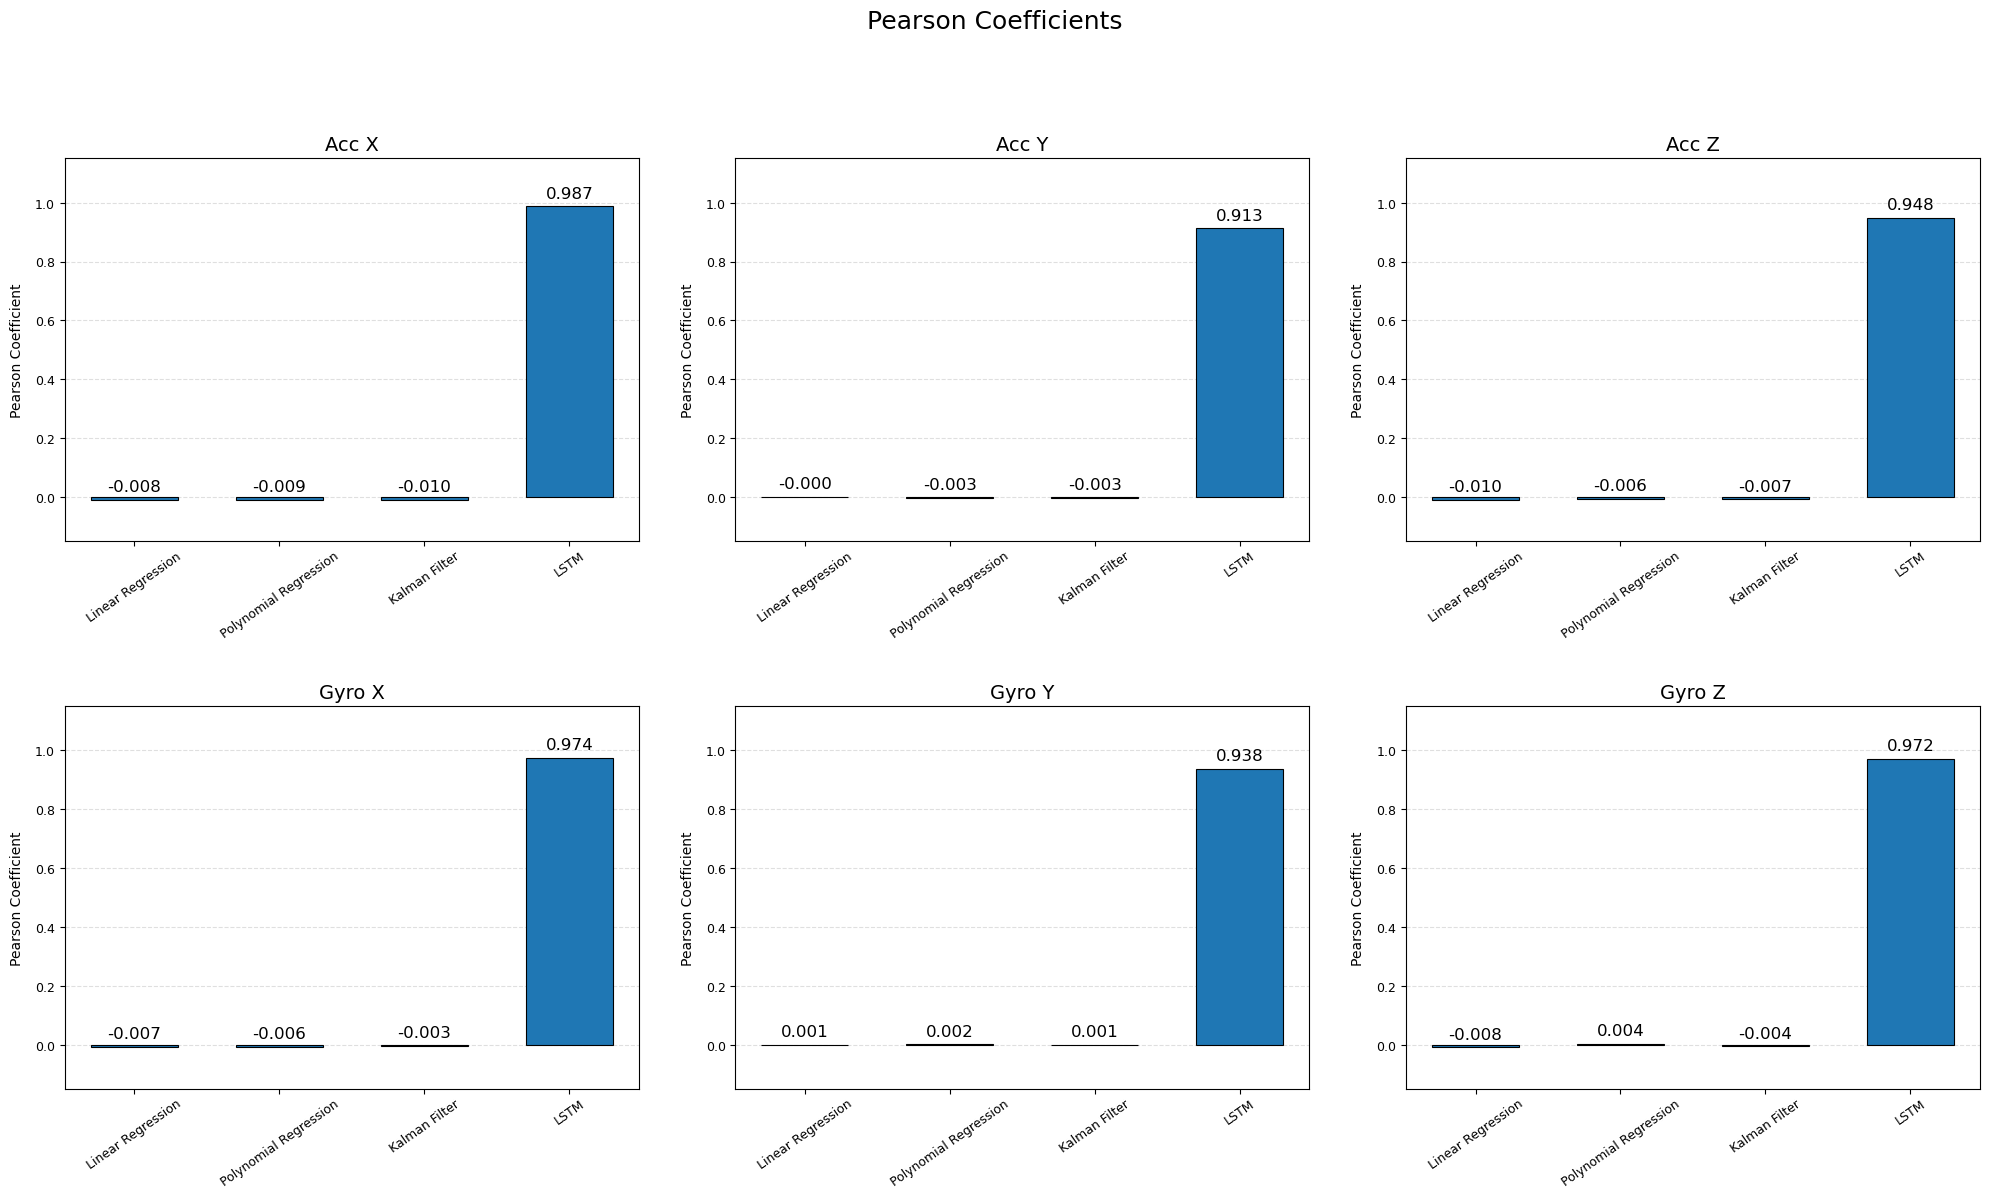

In [ ]:
# Data from your evaluations
features = ["Acc X", "Acc Y", "Acc Z", "Gyro X", "Gyro Y", "Gyro Z"]
models = ["Linear Regression", "Polynomial Regression", "Kalman Filter", "LSTM"]

# Correlation data 
correlations = {
    'Linear Regression': linear_corr,
    'Polynomial Regression': poly_corr,
    'Kalman Filter': kalman_corr,
    'LSTM': lstm_corr
}

# Create figure with constrained layout
fig, axs = plt.subplots(2, 3, figsize=(20, 12), dpi=100)
fig.suptitle('Pearson Coefficients', fontsize=18, y=1.02)

# Plot each feature in its own subplot
for idx in range(6):
    row = idx // 3
    col = idx % 3
    ax = axs[row, col]
    
    # Get correlations for this feature
    corr_values = [correlations[model][idx] for model in models]
    
    # Create bars 
    bars = ax.bar(models, corr_values, width=0.6, edgecolor='black', linewidth=0.8)
    
    # Formatting
    ax.set_title(f'{features[idx]}', fontsize=14)
    ax.set_ylim(-0.15, 1.15)
    ax.set_ylabel('Pearson Coefficient', fontsize=10, labelpad=8)
    ax.tick_params(axis='x', rotation=35, labelsize=9, pad=2)
    ax.tick_params(axis='y', labelsize=9)
    
    # Add light grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.set_axisbelow(True)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, 
                    color='black')

# Remove legend (or you can keep it without colors if needed)
# handles = [plt.Rectangle((0,0),1,1, color='gray', edgecolor='black') for model in models]
# fig.legend(handles, models, loc='lower center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, -0.03), frameon=True, shadow=True)

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.96], h_pad=3, w_pad=3)
plt.subplots_adjust(bottom=0.12)  # Make space for legend (if kept)

# Save high quality version
plt.savefig('pearson_correlations.png', 
           bbox_inches='tight', 
           dpi=300,
           facecolor='white')

plt.show()

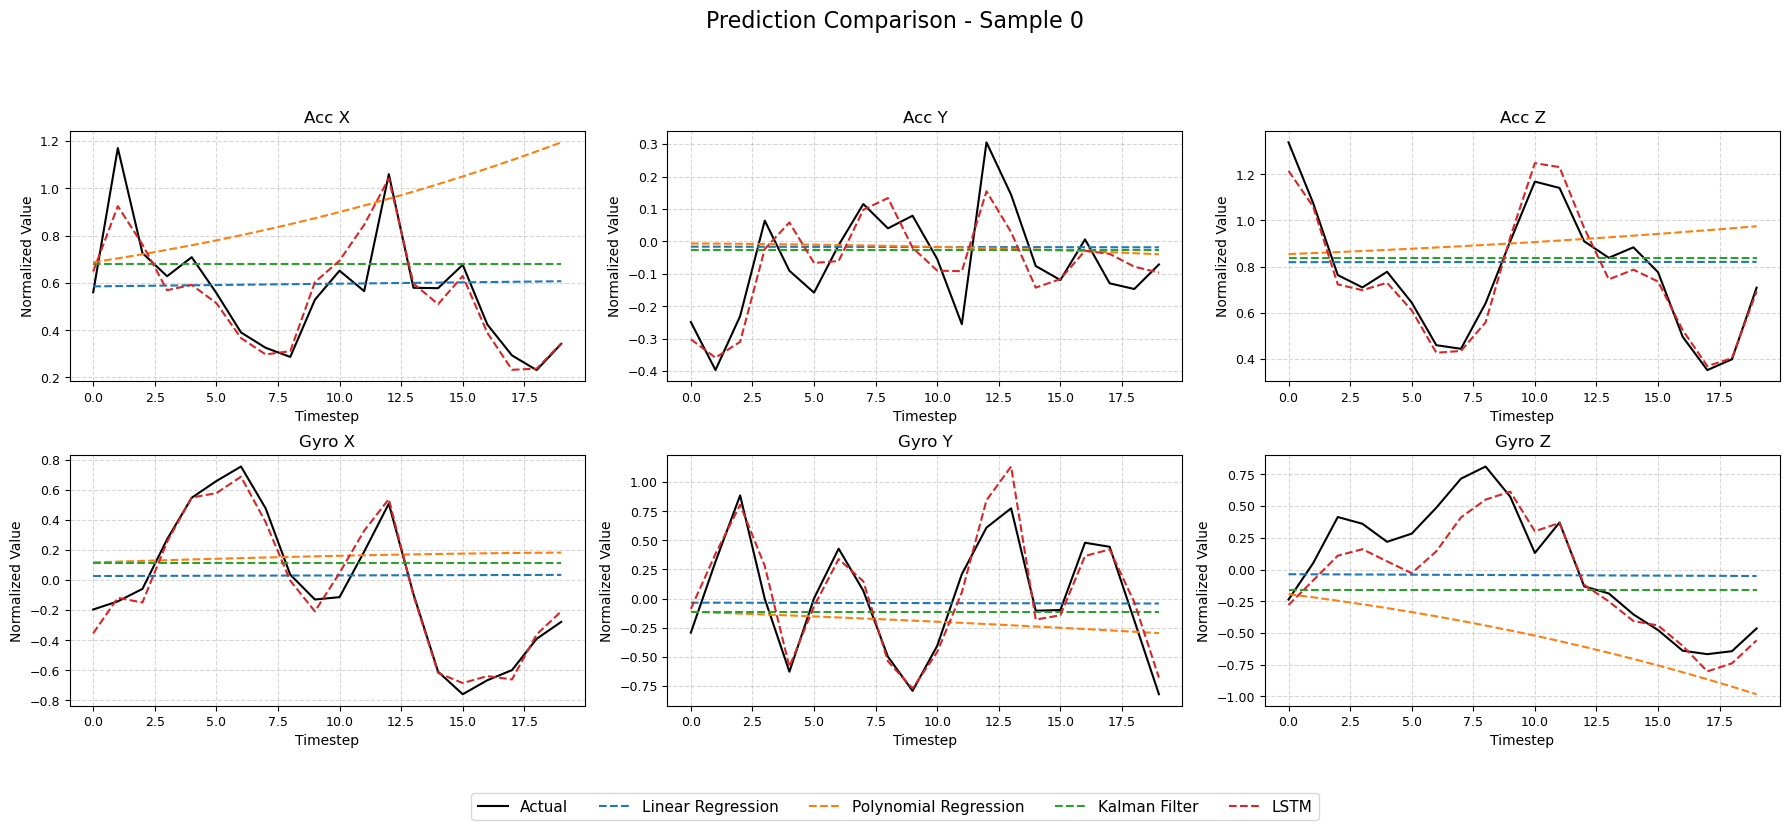

In [ ]:
def plot_predictions_comparison_grid(actuals, predictions_dict, sample_idx=0):
    features = ["Acc X", "Acc Y", "Acc Z", "Gyro X", "Gyro Y", "Gyro Z"]
    time_steps = np.arange(PREDICT_LEN)
    models = list(predictions_dict.keys())
    # colors = ['r', 'g', 'b', 'm']  # match to number of models

    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle(f'Prediction Comparison - Sample {sample_idx}', fontsize=16, y=1.02)

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]

        # Plot actual
        ax.plot(time_steps, actuals[sample_idx, :, i], 'k-', linewidth=1.5, label='Actual')

        # Plot each model's prediction
        for j, (model_name, preds) in enumerate(predictions_dict.items()):
            ax.plot(time_steps, preds[sample_idx, :, i], 
                    linestyle='--', linewidth=1.5, label=model_name)

        ax.set_title(features[i])
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(labelsize=9)

    # Unified legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=11)
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.subplots_adjust(bottom=0.15)
    # plt.savefig(f'comparison_grid_sample_{sample_idx}.png', dpi=300)
    plt.show()

predictions_dict = {
    "Linear Regression": linear_preds,
    "Polynomial Regression": poly_preds,
    "Kalman Filter": kalman_preds,
    "LSTM": lstm_preds
}

# Choose a few samples
for sample in [0]:
    plot_predictions_comparison_grid(actuals, predictions_dict, sample_idx=sample)